In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(r'C:\Users\Mohamed Fawzi\Desktop\Warehouse Sales\Warehouse_and_Retail_Sales.csv')

df.head(2)

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.0,0.0,2.0
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.0,1.0,4.0


# Cleaning & Preparing The Data

In [3]:
# I will convert all columns name to be title case - I prefer it like that :)
df.columns = df.columns.str.title()

In [4]:
# drop null values
df.dropna(inplace=True)

In [5]:
df.isna().sum()

Year                0
Month               0
Supplier            0
Item Code           0
Item Description    0
Item Type           0
Retail Sales        0
Retail Transfers    0
Warehouse Sales     0
dtype: int64

In [6]:
# exclude 'STR_SUPPLIES', 'KEGS', 'REF', 'DUNNAGE', because most of the values are zeros
df = df[df['Item Type'].isin(['WINE', 'BEER', 'LIQUOR','NON-ALCOHOL'])]

In [7]:
df['Item Type'].unique()


array(['WINE', 'BEER', 'LIQUOR', 'NON-ALCOHOL'], dtype=object)

In [8]:
# Calculate mean values for only saleable items
saleable_items = ['WINE', 'BEER', 'LIQUOR', 'NON-ALCOHOL']  # Define saleable items
mean_values = df[df['Item Type'].isin(saleable_items)].groupby('Item Type')[['Warehouse Sales', 'Retail Transfers', 'Retail Sales']].mean()

# Define a function to replace zeros
def replace_zeros_with_mean(row, mean_values):
    item_type = row['Item Type']
    for col in ['Warehouse Sales', 'Retail Transfers', 'Retail Sales']:
        if row[col] == 0.0 and item_type in mean_values.index:
            row[col] = mean_values.loc[item_type, col]  # Replace zero with mean for this item type
    return row

# Apply the function to rows where the item type is saleable
df = df.apply(replace_zeros_with_mean, mean_values=mean_values, axis=1)

In [9]:
df.sample()

,Year,Month,Supplier,Item Code,Item Description,Item Type,Retail Sales,Retail Transfers,Warehouse Sales
250631,2019,8,BARON FRANCOIS LTD,334870,PARK COGNAC XO - 750ML,LIQUOR,0.34,12.243656,1.462121


In [10]:
# converting the Year & Month to datetime
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296862 entries, 0 to 307644
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Year              296862 non-null  int64         
 1   Month             296862 non-null  int64         
 2   Supplier          296862 non-null  object        
 3   Item Code         296862 non-null  object        
 4   Item Description  296862 non-null  object        
 5   Item Type         296862 non-null  object        
 6   Retail Sales      296862 non-null  float64       
 7   Retail Transfers  296862 non-null  float64       
 8   Warehouse Sales   296862 non-null  float64       
 9   Date              296862 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 24.9+ MB


In [11]:
# Convert numeric columns to float
numeric_columns = ['Retail Sales', 'Retail Transfers', 'Warehouse Sales']

df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
#df.info()


In [12]:
# extract month name from the date column that I created earlier
df['Month Name'] = df['Date'].dt.month_name()

# Exploratory Data Analysis (EDA):

##  Supplier Performance Analysis

### Top 5 Supliers

Now we'll analyze the top 5 supplier by Warehouse and Retail Sales

In [13]:
top_suppliers = df.groupby('Supplier')[['Warehouse Sales', 'Retail Sales']].sum().reset_index().round(2)

top_suppliers_whs = top_suppliers.sort_values(by='Warehouse Sales', ascending=False).head()

top_suppliers_rs = top_suppliers.sort_values(by='Retail Sales', ascending=False).head()

top_suppliers_rs

,Supplier,Warehouse Sales,Retail Sales
108,E & J GALLO WINERY,206791.06,168177.84
90,DIAGEO NORTH AMERICA INC,175845.86,149495.80
15,ANHEUSER BUSCH INC,1394450.59,134804.49
76,CONSTELLATION BRANDS,124496.31,132605.41
188,LEGENDS LTD,187396.44,116584.09


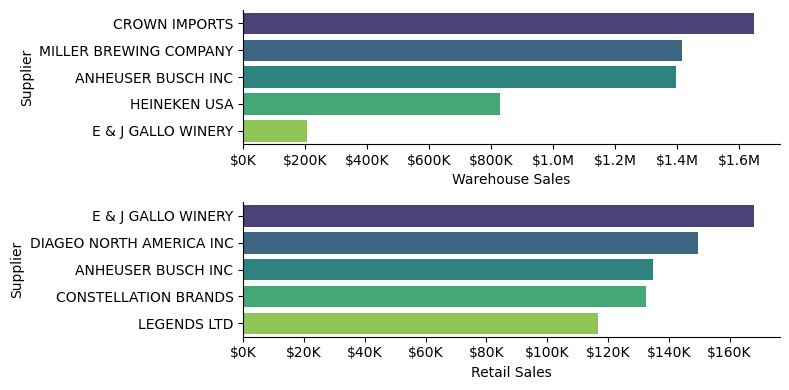

In [15]:
# plotting top_suppliers as subplot
fig, axes = plt.subplots(2, 1, figsize=(8, 4))

sns.barplot(
    data=top_suppliers_whs,
    x='Warehouse Sales',
    y='Supplier',
    palette='viridis',
    ax=axes[0]
)

sns.barplot(
    data=top_suppliers_rs,
    x='Retail Sales',
    y='Supplier',
    palette='viridis',
    ax=axes[1]
)

def format_currency(x, pos):
    if x >= 1e6:
        return '${:1.1f}M'.format(x*1e-6)
    else:
        return '${:1.0f}K'.format(x*1e-3)

# currency format
axes[0].xaxis.set_major_formatter(FuncFormatter(format_currency))
axes[1].xaxis.set_major_formatter(FuncFormatter(format_currency))

sns.despine()
plt.tight_layout()
plt.show()

 **Key Insights:**

#### **Warehouse Sales**
1. **CROWN IMPORTS Dominates**:  
   - CROWN IMPORTS leads with the highest warehouse sales, reaching approximately **$1.4 million**.  
   - This indicates strong wholesale demand for their products.

2. **ANHEUSER-BUSCH INC and MILLER BREWING COMPANY Follow Closely**:  
   - Both have significant warehouse sales, around **$1 million**, suggesting they are major suppliers in the wholesale channel.

3. **HEINEKEN USA Shows Moderate Performance**:  
   - HEINEKEN USA has warehouse sales of about **$0.7 million**, indicating a solid but not dominant position.

4. **E & J GALLO WINERY Lags Behind**:  
   - E & J GALLO WINERY has the lowest warehouse sales among the listed suppliers, at around **$0.2 million**.  
   - This could indicate limited wholesale distribution or focus on retail channels.

---

#### **Retail Sales**
1. **E & J GALLO WINERY Leads Retail Sales**:  
   - E & J GALLO WINERY tops the chart with retail sales of approximately **$1.4 million**, showcasing strong direct-to-consumer appeal.

2. **CONSTELLATION BRANDS and ANHEUSER-BUSCH INC Are Close Competitors**:  
   - CONSTELLATION BRANDS and ANHEUSER-BUSCH INC both have robust retail sales, around **$1.2 million** and **$1.1 million**, respectively.  
   - This suggests these suppliers are well-positioned in both wholesale and retail markets.

3. **DIAGEO NORTH AMERICA INC and MILLER BREWING COMPANY Show Moderate Retail Presence**:  
   - DIAGEO NORTH AMERICA INC has retail sales of about *$1 million*, while MILLER BREWING COMPANY Com is slightly lower, around $0.8 million.  
   - These suppliers have a balanced presence across both channels.

4. **No Supplier Dominates Both Channels Simultaneously**:  
   - CROWN IMPORTS excels in warehouse sales but does not appear in the top retail performers.  
   - E & J GALLO WINERY dominates retail sales but lags in warehouse sales.  
   - This highlights different supplier strategies for wholesale vs. retail.



### **Summary of Observations:**
- **CROWN IMPORTS** excels in wholesale sales, making it a key partner for bulk orders.
- **E & J GALLO WINERY** dominates retail sales, indicating strong consumer appeal.
- **ANHEUSER-BUSCH INC and CONSTELLATION BRANDS** balance both channels effectively.
- **HEINEKEN USA and MILLER BREWING COMPANY** show moderate performance across channels.

---

### Transfer Ratio by Supplier

Now, let's calculate the avergae transfer effciency for top 10 suppliers

In [16]:
df['Transfer Ratio'] = df['Retail Transfers'] / df['Warehouse Sales'].replace(0, np.nan)

In [17]:
top_transfers = df.groupby('Supplier')['Transfer Ratio'].mean().nlargest(10).reset_index().round(2)
top_transfers

,Supplier,Transfer Ratio
0,CHARLES JACQUIN ET CIE INC,45.90
1,FIFTH GENERATION INC,28.70
2,CALVERT BREWING COMPANY,13.36
3,HEAVEN HILL DISTILLERIES INC,12.70
4,MONTEBELLO BRANDS INC,12.66
5,PROXIMO SPIRITS INC,11.65
6,WILLIAM GRANT AND SONS INC,11.44
7,JIM BEAM BRANDS CO,11.16
8,BACARDI USA INC,11.15
9,RUSSIAN STANDARD VODKA (USA) INC,10.86


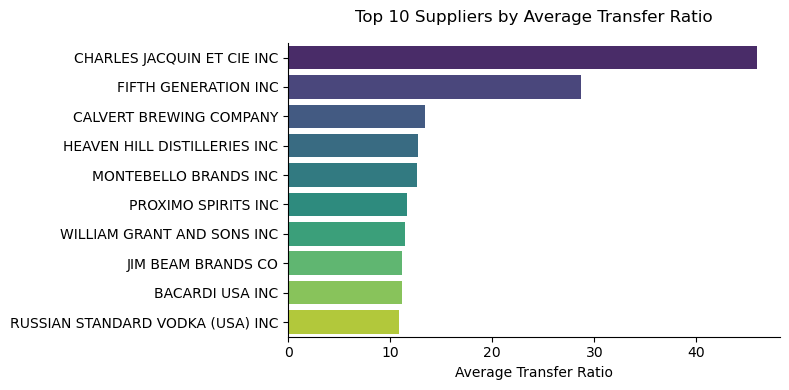

In [18]:
plt.figure(figsize=(8, 4))
sns.barplot(
    data=top_transfers,
    x='Transfer Ratio',
    y='Supplier',
    palette='viridis'
)

plt.title('Top 10 Suppliers by Average Transfer Ratio', pad=15)
plt.xlabel('Average Transfer Ratio')
plt.ylabel('')


sns.despine()
plt.tight_layout()
plt.show()

#### **Key Insights:**

This bar chart shows the **Top 10 Suppliers by Average Transfer Ratio**, highlighting which suppliers have the highest average transfer ratios. Here are the key observations:

---

#### **1. FIFTH GENERATION INC Leads Significantly**
- **Average Transfer Ratio**: Approximately **31**.
- **Insight**: FIFTH GENERATION INC has the highest average transfer ratio among all suppliers, indicating that a large portion of their products are being transferred (likely from warehouses to retail locations or other channels). This suggests:
  - Efficient inventory management and high demand for their products.
  - Strong alignment between wholesale and retail operations.

#### **2. PROXIMO SPIRITS INC and JIM BEAM BRANDS CO Follow Closely**
- **PROXIMO SPIRITS INC**: Average transfer ratio around **20**.
- **JIM BEAM BRANDS CO**: Average transfer ratio around **17**.
- **Insight**: These suppliers also demonstrate strong performance in terms of product transfers. Their high transfer ratios suggest:
  - Consistent demand for their products across different channels.
  - Effective supply chain management to ensure timely delivery to retail locations.

#### **3. Middle-Ranking Suppliers Show Moderate Performance**
- **HEAVEN HILL DISTILLERIES INC**, **DIAGEO NORTH AMERICA INC**, and **SAZERAC CO** have average transfer ratios ranging from **15 to 17**.
- **DISARONNO INTERNATIONAL LLC** and **WILLIAM GRANT AND SONS INC** have slightly lower ratios, around **14**.
- **Insight**: These suppliers maintain a balanced performance, indicating steady demand and efficient inventory flow. However, they may not be as dominant as the top performers.

#### **4. BACARDI USA INC and CAMPARI AMERICA LLC Lag Behind**
- **BACARDI USA INC**: Average transfer ratio around **13**.
- **CAMPARI AMERICA LLC**: Average transfer ratio around **12**.
- **Insight**: These suppliers have the lowest transfer ratios among the top 10. This could indicate:
  - Lower demand for their products compared to others.
  - Potential inefficiencies in inventory management or distribution processes.
  - A focus on direct-to-consumer sales rather than wholesale transfers.

---